# fvGP comprehensive test

## (0) Setup

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from fvgp.gp import GP
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
#!pip list


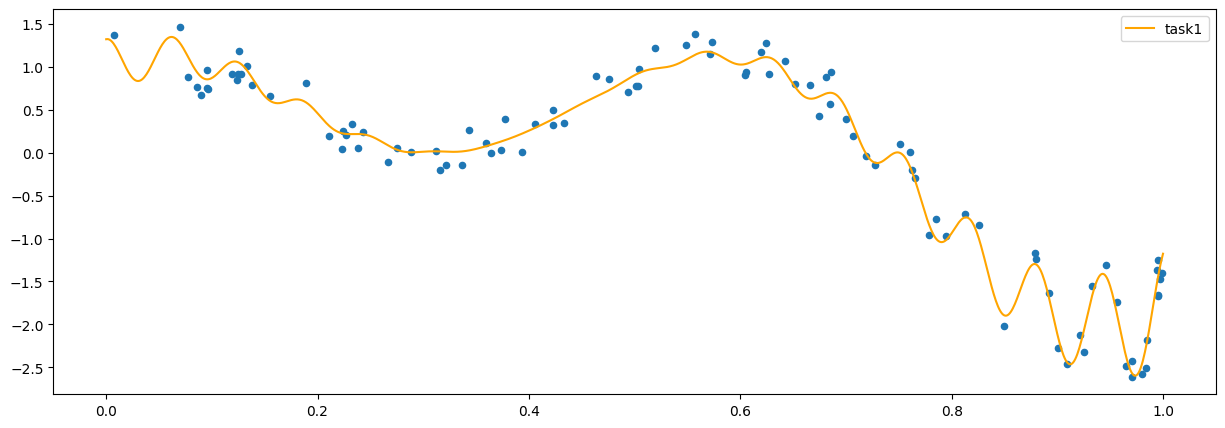

In [12]:
x = np.linspace(0,1,1000)
def f1(x):
    return np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)

x_data = np.random.rand(100)
y_data = f1(x_data) + (np.random.rand(len(x_data))-0.5) * 0.5
plt.figure(figsize = (15,5))
plt.plot(x,f1(x), color = 'orange', label = 'task1')
plt.legend()
plt.scatter(x_data,y_data, s = 20)

In [13]:
#stationary
def skernel(x1,x2,hps,obj):
    d = obj._get_distance_matrix(x1,x2)
    return hps[0] * obj.matern_kernel_diff1(d,hps[1])

def noise(x, hps,obj):
    #print("noise evaluated")
    return np.diag(np.zeros((len(x))) + hps[2])


def meanf(x, hps, obj):
    #print(np.sin(hps[3] * x))
    return np.sin(hps[3] * x)[:,0]
#plt.figure(figsize = (15,5))
#plt.plot(x,meanf(x, np.array([1.,1.,5.0]), None), color = 'orange', label = 'task1')

In [18]:
my_gp1 = GP(1, x_data,y_data,
            #init_hyperparameters = np.ones((4)),
            noise_variances=None, 
            compute_device='cpu', 
            gp_kernel_function=skernel, 
            gp_kernel_function_grad=None, 
            gp_mean_function=meanf, 
            gp_mean_function_grad=None,
            gp_noise_function=noise,
            normalize_y=False,
            sparse_mode=False,
            gp2Scale = False,
            store_inv=True, 
            ram_economy=False, 
            args=None,
            )


print("Data Plot:")
plt.scatter(my_gp1.x_data,my_gp1.y_data, s = 20)
plt.show()
x_pred = np.linspace(0,1,1000)


hps_bounds = np.array([[0.001,10.],[0.001,10.],[0.001,10.],[0.001,10.]])

my_gp1.update_gp_data(x_data, y_data)
print("Standard Training")
my_gp1.train()


print("Global Training")
my_gp1.train(hps_bounds, method='global')
print("hps: ", my_gp1.get_hyperparameters())
print("Local Training")
my_gp1.train(hps_bounds, method='local')
print(my_gp1.get_hyperparameters())
print("MCMC Training")
my_gp1.train(hps_bounds, method='mcmc', max_iter=1000)
print(my_gp1.get_hyperparameters())
my_gp1.train(hps_bounds, method='hgdl')


type: index 2 is out of bounds for axis 0 with size 2

In [ ]:
my_gp1.test_log_likelihood_gradient(my_gp1.hyperparameters)

In [ ]:
my_gp1.train(hps_bounds, method='hgdl', max_iter = 5)

In [ ]:
opt_obj = my_gp1.train_async(hps_bounds)

In [ ]:
my_gp1.update_hyperparameters(opt_obj)
for entry in opt_obj.optima.list:
    print(entry)
    print("")

#my_gp1.entropy(my_gp1.prior_covariance)

In [ ]:
#let's make a prediction
mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1))["v(x)"]

plt.figure(figsize = (16,10))
plt.plot(x,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x,f1(x), label = "latent function", linewidth = 4)
plt.fill_between(x, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
#plt.plot(x, (f(x)-mean1)**2)
plt.scatter(x_data,y_data, color = 'black')
#plt.legend(fontsize = 20)
plt.xticks([])
plt.yticks([])
print("error: ", np.sum(f1(x)-mean1)**2 / len(mean1))

In [ ]:
my_gp1.stop_training(opt_obj)
my_gp1.kill_training(opt_obj)

In [8]:
from dask.distributed import Client
client = Client()
input_dim = 3
N = 10000
x_data = np.random.rand(N,input_dim)
y_data = np.sin(np.linalg.norm(x_data,axis = 1) * 5.0)
hps_n = 42

hps_bounds = np.array([
                                [0.,1.],   ##pos bump 1 f comp 1
                                [0.,1.],    ##pos bump 1 f comp 2
                                [0.,1.],  ##pos bump 1 f comp 3
                                #
                                [0.,1.],   ##pos bump 2 f
                                [0.,1.],    ##pos bump 2 f
                                [0.,1.],    ##pos bump 2 f
                                #
                                [0.,1.],   ##pos bump 3 f
                                [0.,1.],    ##pos bump 3 f
                                [0.,1.],    ##pos bump 3 f
                                #
                                [0.,1.],   ##pos bump 4 f
                                [0.,1.],    ##pos bump 4 f
                                [0.,1.],    ##pos bump 4 f
                                #
                                [0.01,0.01],    ##radius bump 1 f
                                [0.01,0.01],    ##...2
                                [0.01,0.01],    ##...3
                                [0.01,0.01],    ##...4
                                [0.1,1.],    ##ampl bump 1 f
                                [0.1,1.],    ##...2
                                [0.1,1.],    ##...3
                                [0.1,1.],    ##...4
                                #
                                [0.,1.],    ##pos bump 1 g comp 1
                                [0.,1.],     ##pos bump 1 g comp 2
                                [0.,1.],   ##pos bump 1 g comp 3
                                #
                                [0.,1.],    ##pos bump 2 g comp 1
                                [0.,1.],     ##pos bump 2 g comp 2
                                [0.,1.],   ##pos bump 2 g comp 3
                                #
                                [0.,1.],    ##pos bump 3 g comp 1
                                [0.,1.],     ##pos bump 3 g comp 2
                                [0.,1.],   ##pos bump 3 g comp 3
                                #
                                [0.,1.],    ##pos bump 4 g comp 1
                                [0.,1.],     ##pos bump 4 g comp 2
                                [0.,1.],   ##pos bump 4 g comp 3
                                #
                                [0.01,0.01],    ##radius bump 1 g
                                [0.01,0.01],    ##...2
                                [0.01,0.01],    ##...3
                                [0.01,0.01],    ##...4
                                [0.1,1.],    ##ampl bump 1 g
                                [0.1,1.],    ##...2
                                [0.1,1.],    ##...3
                                [0.1,1.],    ##...4
                                [0.1,10.],    ##signal var of stat kernel
                                [0.001,0.0002]     ##length scale for stat kernel
                                ])


init_hps = np.random.uniform(size = len(hps_bounds), low = hps_bounds[:,0], high = hps_bounds[:,1])
from fvgp.advanced_kernels import kernel_cpu

my_gp2S = GP(3, x_data,y_data,init_hps, 
            gp_kernel_function=kernel_cpu, 
            gp2Scale = True, gp2Scale_batch_size= 1000, gp2Scale_dask_client=client
            )



#my_gp2S.train(hps_bounds, max_iter = 2, init_hyperparameters = init_hps)
       

/home/marcus/VirtualEnvironments/fvgp_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45853 instead
  warnings.warn(


We have  3  compute workers ready to go.
Actor on tcp://127.0.0.1:35975
Scheduler Address:  tcp://127.0.0.1:39199
    submitted batch. i: 0 1000    j: 0 1000 to worker  tcp://127.0.0.1:45691  Future:  kernel_function-1e46aa349eb2fedf5589a73917f8d95e
    current time stamp:  0.0016407966613769531  percent finished:  0.0

    submitted batch. i: 0 1000    j: 1000 2000 to worker  tcp://127.0.0.1:41861  Future:  kernel_function-b47e4cd2f72b2a1cf3b3d64be9488070
    current time stamp:  0.0039408206939697266  percent finished:  0.01818181818181818

    submitted batch. i: 0 1000    j: 2000 3000 to worker  tcp://127.0.0.1:37047  Future:  kernel_function-23841dca3d361b462fd085998a8e7809
    current time stamp:  0.005738973617553711  percent finished:  0.03636363636363636



/tmp/ipykernel_2221369/1721198049.py:67: UserWarning: No noise function or measurement noise provided. Noise variances will be set to 1% of mean(y_data).
  my_gp2S = GP(3, x_data,y_data,init_hps,


    submitted batch. i: 0 1000    j: 3000 4000 to worker  tcp://127.0.0.1:45691  Future:  kernel_function-842e7c484dd931c36d9aaedcd82b98e4
    current time stamp:  0.310396671295166  percent finished:  0.05454545454545454

    submitted batch. i: 0 1000    j: 4000 5000 to worker  tcp://127.0.0.1:41861  Future:  kernel_function-8ccd00a00ffda3a1350c9ce9f9f654c8
    current time stamp:  0.31276559829711914  percent finished:  0.07272727272727272

    submitted batch. i: 0 1000    j: 5000 6000 to worker  tcp://127.0.0.1:37047  Future:  kernel_function-0de88bd16ddc22ab268d6c4f0e03d874
    current time stamp:  0.314727783203125  percent finished:  0.09090909090909091

    submitted batch. i: 0 1000    j: 6000 7000 to worker  tcp://127.0.0.1:45691  Future:  kernel_function-d5bc7869a4f85590952558415bd04f1f
    current time stamp:  0.5190145969390869  percent finished:  0.10909090909090909

    submitted batch. i: 0 1000    j: 7000 8000 to worker  tcp://127.0.0.1:41861  Future:  kernel_function

    current time stamp:  2.80523681640625  percent finished:  0.7090909090909091

    submitted batch. i: 5000 6000    j: 5000 6000 to worker  tcp://127.0.0.1:41861  Future:  kernel_function-df5d516f577698c4ef46580ba4e305df
    current time stamp:  2.806995391845703  percent finished:  0.7272727272727273

    submitted batch. i: 5000 6000    j: 6000 7000 to worker  tcp://127.0.0.1:37047  Future:  kernel_function-7317c0f98b0e1d93f2a41b004f551456
    current time stamp:  2.81069278717041  percent finished:  0.7454545454545455

    submitted batch. i: 5000 6000    j: 7000 8000 to worker  tcp://127.0.0.1:45691  Future:  kernel_function-55e2da1f23b5eb601891f5ebe4b660cf
    current time stamp:  3.0143752098083496  percent finished:  0.7636363636363637

    submitted batch. i: 5000 6000    j: 8000 9000 to worker  tcp://127.0.0.1:41861  Future:  kernel_function-b969cbc90222c3bbe9d0472bcf816dd9
    current time stamp:  3.0171449184417725  percent finished:  0.7818181818181819

    submitted bat

## Multi Task

In [ ]:
from fvgp.fvgp import fvGP

x = np.linspace(0,1,1000)
def f1(x):
    return np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)

def f2(x):
    return np.sin(5. * x) + np.cos(2. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)

x_data = np.random.rand(100)
y_data = np.empty((len(x_data),2))
y_data[:,0] = f1(x_data) + (np.random.rand(len(x_data))-0.5) * 0.5
y_data[:,1] = f2(x_data) + (np.random.rand(len(x_data))-0.5) * 0.5
plt.figure(figsize = (15,5))
plt.plot(x,f1(x), color = 'orange', label = 'task1')
plt.plot(x,f2(x), color = 'green',  label = 'task2')
plt.legend()
plt.scatter(x_data,y_data[:,0], s = 20)
plt.scatter(x_data,y_data[:,1], s = 20)

my_gp2 = fvGP(1, 1, 2, x_data,y_data,np.ones((4)),
            noise_variances=None, 
            compute_device='cpu', 
            gp_kernel_function=None, 
            gp_kernel_function_grad=None, 
            gp_mean_function=meanf, 
            gp_mean_function_grad=None,
            gp_noise_function=None,
            normalize_y=False,
            sparse_mode=False,
            store_inv=True, 
            ram_economy=False, 
            args=None,
            )


print("Data Plot:")
plt.scatter(my_gp1.x_data,my_gp1.y_data, s = 20)
plt.show()
x_pred = np.linspace(0,1,1000)


hps_bounds = np.array([[0.001,10.],[0.001,10.],[0.001,10.],[0.001,10.]])

#my_gp1.update_gp_data(x_data, y_data)
print("Global Training")
my_gp2.train(my_gp2.hps_bounds, method='global')
#print("hps: ", my_gp1.get_hyperparameters())
#print("Local Training")
#my_gp1.train(hps_bounds, method='local')
#print(my_gp1.get_hyperparameters())
#print("MCMC Training")
#my_gp1.train(hps_bounds, method='mcmc', max_iter=1000)
#print(my_gp1.get_hyperparameters())

In [ ]:
my_gp2.input_space_dim


In [ ]:
#let's make a prediction
res = my_gp2.posterior_mean(x_pred.reshape(-1,1), x_out=np.array([[0],[1]]), hyperparameters=np.array([1,1,1,1]))
mean2 = res["f(x)"][0:1000]
var2 =  my_gp2.posterior_covariance(x_pred.reshape(-1,1), x_out=np.array([[0],[1]]))["v(x)"][0:1000]

plt.figure(figsize = (16,10))
plt.plot(x,mean2, label = "posterior mean", linewidth = 4)
plt.plot(x,f1(x), label = "latent function", linewidth = 4)
plt.fill_between(x, mean2 - 3. * np.sqrt(var2), mean2 + 3. * np.sqrt(var2), alpha = 0.5, color = "grey", label = "var")
#plt.plot(x, (f(x)-mean1)**2)
plt.scatter(x_data,y_data[:,0], color = 'black')
#plt.legend(fontsize = 20)
plt.xticks([])
plt.yticks([])
print("error: ", np.sum(f1(x)-mean1)**2 / len(mean1))

# Performance Tests